# 🤗 Bert for Question Answering Baseline: Training

This code is adapted from my work in the Tweet Sentiment Extraction Competition.

It tackles the task as a Question Answering one, where the question is implicit and can be understood as : "Which datasets are mentionned ?"


The approach is quite naïve and has a lot of flaws. Feel free to ask any question in the comments.

Inference Kernel : https://www.kaggle.com/theoviel/bert-for-question-answering-baseline-inference

# Initialization

## Imports

In [1]:
import re
import os
import gc
import glob
import json
import time
import torch
import random
import datetime
import tokenizers
import numpy as np
import transformers
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from tokenizers import *
from transformers import *
from functools import partial
from tqdm.notebook import tqdm
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold

## Params

In [2]:
SEED = 2020

DATA_PATH = "../input/coleridgeinitiative-show-us-the-data/"
DATA_PATH_TRAIN = DATA_PATH + 'train/'
DATA_PATH_TEST = DATA_PATH + 'test/'

NUM_WORKERS = 4

VOCABS = {
    "bert-base-uncased": "../input/vocabs/bert-base-uncased-vocab.txt",
}

MODEL_PATHS = {
    'bert-base-uncased': '../input/bertconfigs/uncased_L-12_H-768_A-12/uncased_L-12_H-768_A-12/',
    'bert-large-uncased-whole-word-masking-finetuned-squad': '../input/bertconfigs/wwm_uncased_L-24_H-1024_A-16/wwm_uncased_L-24_H-1024_A-16/',
    'albert-large-v2': '../input/albert-configs/albert-large-v2/albert-large-v2/',
    'albert-base-v2': '../input/albert-configs/albert-base-v2/albert-base-v2/',
    'distilbert': '../input/albert-configs/distilbert/distilbert/',
}

# Data Preparation
Instead of having labels at article level, I refine the definition to section level. This allows for less sparsity. 

In [3]:
def load_text(id_, root=""):
    with open(os.path.join(root, id_ + ".json")) as f:
        text = json.load(f)
    return text


def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()


def create_data():
    new_df = []

    for idx in tqdm(range(len(df))):
        article = load_text(df['Id'][idx], DATA_PATH_TRAIN)
        id_, pub_title, dataset_title, dataset_label, cleaned_label = df.iloc[idx]
        
        
        for i, section in enumerate(article):
            text = section['text']
            title = section['section_title']
            
            cleaned_text = clean_text(section['text'])
            
            found = cleaned_label in cleaned_text
    
            dic = {
                "id": [id_], 
                "section_id": [i],
                "pub_title": [pub_title], 
                "dataset_title": [dataset_title], 
                "dataset_label": [dataset_label], 
                "cleaned_label": [cleaned_label],
                "text": [text],
                "cleaned_text": [cleaned_text],
                "label_found": [found],
            }
            new_df.append(pd.DataFrame.from_dict(dic))
            
    return pd.concat(new_df).reset_index(drop=True)

In [4]:
df = pd.read_csv(DATA_PATH + 'train.csv')

new_df = create_data()  # Quite slow, could be sped-up with multi-processing.

  0%|          | 0/19661 [00:00<?, ?it/s]

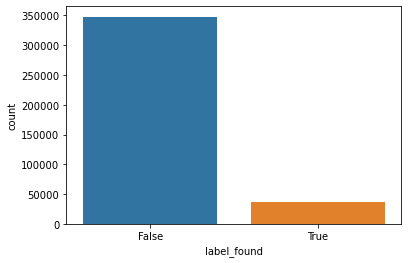

In [5]:
sns.countplot(x=new_df['label_found'])
plt.show()

A lot of sections have no label found, I won't use them for training.

In [6]:
df = new_df[new_df['label_found']].reset_index(drop=True)

df['length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df = df[df['length'] < 3000]  # remove too long texts

df.to_csv("df_train.csv", index=False)  # saving, just in case

# Training a Model

# Utils

In [7]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.

    Args:
        seed (int): Number of the seed.
    """

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def save_model_weights(model, filename, verbose=1, cp_folder=""):
    """
    Saves the weights of a PyTorch model.

    Args:
        model (torch model): Model to save the weights of.
        filename (str): Name of the checkpoint.
        verbose (int, optional): Whether to display infos. Defaults to 1.
        cp_folder (str, optional): Folder to save to. Defaults to "".
    """

    if verbose:
        print(f"\n -> Saving weights to {os.path.join(cp_folder, filename)}\n")
    torch.save(model.state_dict(), os.path.join(cp_folder, filename))


def count_parameters(model, all=False):
    """
    Count the parameters of a model.

    Args:
        model (torch model): Model to count the parameters of.
        all (bool, optional):  Whether to count not trainable parameters. Defaults to False.

    Returns:
        int: Number of parameters.
    """

    if all:
        return sum(p.numel() for p in model.parameters())
    else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Data

## Tokenizer

In [8]:
class EncodedText:
    def __init__(self, ids, offsets):
        self.ids = ids
        self.offsets = offsets


def create_tokenizer_and_tokens(config):
    if "roberta" in config.selected_model:
        raise NotImplementedError
        
    elif "albert" in config.selected_model:
        raise NotImplementedError
        
    else:
        tokenizer = BertWordPieceTokenizer(
            MODEL_PATHS[config.selected_model] + 'vocab.txt',
            lowercase=config.lowercase,
        )

        tokens = {
            'cls': tokenizer.token_to_id('[CLS]'),
            'sep': tokenizer.token_to_id('[SEP]'),
            'pad': tokenizer.token_to_id('[PAD]'),
        }
    
    return tokenizer, tokens

## Locating labels

In [9]:
def locate_label_string(text, label):
    """
    Finds the label in the text
    """
    len_label = len(label) - 1

    candidates_idx = [i for i, e in enumerate(text) if e == label[1]]
    for idx in candidates_idx:
        if " " + text[idx: idx + len_label] == label:
            idx_start = idx
            idx_end = idx + len_label
            break

    assert (
        text[idx_start:idx_end] == label[1:]
    ), f'"{text[idx_start: idx_end]}" instead of "{label}" in "{text}"'

    char_targets = np.zeros(len(text))
    char_targets[idx_start:idx_end] = 1

    return idx_start, idx_end, char_targets


def locate_label_tokens(offsets, char_targets):
    """
    Finds the tokens corresponding to the found labels
    """
    target_idx = []
    for idx, (offset1, offset2) in enumerate(offsets):
        if sum(char_targets[offset1:offset2]) > 0:
            target_idx.append(idx)

    if not len(target_idx):
        for idx, (offset1, offset2) in enumerate(offsets):
            if sum(char_targets[offset1:offset2]) > 0:
                target_idx.append(idx)

    return target_idx[0], target_idx[-1]

## Process sample

In [10]:
def process_data(
    text,
    label,
    tokenizer,
    tokens,
    max_len=100,
    model_name="bert",
):
    """
    Prepares the data for the question answering task.
    Adapted from Abishek's work on the Tweet Sentiment extraction competition, 
    check his work for more details !
    """
    target_start, target_end = 0, 0
    text = " " + " ".join(str(text).split())
    label = " " + " ".join(str(label).split())

    if label != " ":
        idx_start, idx_end, char_targets = locate_label_string(
            text, label
        )

    tokenized = tokenizer.encode(text)
    input_ids_text = tokenized.ids[1:-1]

    # print(input_ids_text, len(input_ids_text))

    offsets = tokenized.offsets[1:-1]

    if label != " ":
        target_start, target_end = locate_label_tokens(offsets, char_targets)

    if target_end >= max_len - 2:  # target is too far in the sentence, we crop its beginning.
        n_tok_to_crop = target_start - max_len // 2
        new_str_start = offsets[n_tok_to_crop][0]

        input_ids_text = input_ids_text[n_tok_to_crop:]

        offsets = [tuple(t) for t in np.array(offsets[n_tok_to_crop:]) - new_str_start]
        text = text[new_str_start:]

        target_start -= n_tok_to_crop
        target_end -= n_tok_to_crop

    input_ids = (
        [tokens["cls"]]
        + input_ids_text[:max_len - 2]
        + [tokens["sep"]]
    )

    if "roberta" in model_name:
        token_type_ids = [0] * len(input_ids)
    else:
        token_type_ids = [1] * len(input_ids)

    text_offsets = [(0, 0)] + offsets[:max_len - 2] + [(0, 0)]

    target_start += 1
    target_end += 1

    # target_end = min(target_end, max_len - 1)

    assert len(input_ids) == len(token_type_ids) and len(input_ids) == len(text_offsets), (len(input_ids), len(text_offsets))  # noqa

    padding_length = max_len - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([tokens["pad"]] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        text_offsets = text_offsets + ([(0, 0)] * padding_length)

    return {
        "ids": input_ids,
        "token_type_ids": token_type_ids,
        "targets_start": target_start,
        "targets_end": target_end,
        "text": text,
        "label": label,
        "offsets": text_offsets,
    }

### Dataset

In [11]:
class SectionDataset(Dataset):
    def __init__(
        self,
        df,
        tokenizer,
        tokens,
        max_len=512,
        model_name="bert",
    ):
        self.tokens = tokens
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.model_name = model_name

        self.texts = df["cleaned_text"].values
        self.labels = df["cleaned_label"].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        data = process_data(
            self.texts[idx],
            self.labels[idx],
            self.tokenizer,
            self.tokens,
            max_len=self.max_len,
            model_name=self.model_name,
        )

        return {
            "ids": torch.tensor(data["ids"], dtype=torch.long),
            "token_type_ids": torch.tensor(data["token_type_ids"], dtype=torch.long),
            "target_start": torch.tensor(data["targets_start"], dtype=torch.long),
            "target_end": torch.tensor(data["targets_end"], dtype=torch.long),
            "text": data["text"],
            "label": data["label"],
            "offsets": torch.tensor(data["offsets"], dtype=torch.long),
        }

## Model

In [12]:
TRANSFORMERS = {
    "roberta-base": (RobertaModel, "roberta-base"),
    'albert-base-v2': (AlbertModel, 'albert-base-v2'),
    'albert-large-v2': (AlbertModel, 'albert-large-v2'),
    'albert-xlarge-v2': (AlbertModel, 'albert-xlarge-v2'),
    'albert-xxlarge-v2': (AlbertModel, 'albert-xxlarge-v2'),
    "bert-base-uncased": (BertModel, "bert-base-uncased"),
    "bert-base-cased": (BertModel, "bert-base-cased"),
    "bert-large-uncased-whole-word-masking": (BertModel, "bert-large-uncased-whole-word-masking"),
    "distilbert-base-uncased-distilled-squad": (
        DistilBertModel,
        "distilbert-base-uncased-distilled-squad"
    )
}


class QATransformer(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.name = model

        self.pad_idx = 1 if "roberta" in self.name else 0

        model_class, pretrained_weights = TRANSFORMERS[model]

        self.transformer = model_class.from_pretrained(
            pretrained_weights, output_hidden_states=True
        )

        self.nb_features = self.transformer.pooler.dense.out_features

        self.logits = nn.Sequential(
            nn.Linear(self.nb_features, self.nb_features),
            nn.Tanh(),
            nn.Linear(self.nb_features, 2),
        )

    def forward(self, tokens, token_type_ids):
        """
        Usual torch forward function

        Arguments:
            tokens {torch tensor} -- Sentence tokens
            token_type_ids {torch tensor} -- Sentence tokens ids
        """

        hidden_states = self.transformer(
            tokens,
            attention_mask=(tokens != self.pad_idx).long(),
            token_type_ids=token_type_ids,
        )[-1]

        features = hidden_states[-1]
        logits = self.logits(features)

        start_logits, end_logits = logits[:, :, 0], logits[:, :, 1]

        return start_logits, end_logits

## Metric

In [13]:
def jaccard_similarity(s1, s2): # could be wrong, see CPMP's thread
    l1 = s1.split(" ")
    l2 = s2.split(" ")
    intersection = len(list(set(l1).intersection(l2)))
    union = (len(l1) + len(l2)) - intersection
    return float(intersection) / union


def compute_score(y_true, y_pred, beta=0.5):
    """
    From https://www.kaggle.com/tungmphung/coleridge-initiative-local-score-computation/
    """
    TP, FP, FN = 0, 0, 0

    for truth, pred in zip(y_true, y_pred):
        true_datasets = truth.split('|')
        # Predicted strings for each publication are sorted alphabetically
        # and processed in that order.
        pred_datasets = sorted(pred.split('|'))

        for true_dataset in true_datasets:
            if len(pred_datasets):
                match_scores = [jaccard_similarity(true_dataset, pred_dataset)
                                for pred_dataset in pred_datasets]
                # The prediction with the highest score for a given ground truth
                # is matched with that ground truth.
                match_index = np.argmax(match_scores)

                if match_scores[match_index] >= 0.5:
                    # Any matched predictions where the Jaccard score meets or
                    # exceeds the threshold of 0.5 are counted as true positives (TP),
                    TP += 1
                else:
                    # the remainder as false positives (FP).
                    FP += 1

                del(pred_datasets[match_index])
            else:
                # Any ground truths with no nearest predictions are counted as
                # false negatives (FN).
                FN += 1
        # Any unmatched predictions are counted as false positives (FP).
        FP += len(pred_datasets)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = (1 + beta**2)*(precision*recall)/((beta**2)*precision + recall)

    return f_score

## Preds from probas

In [14]:
def get_string_from_idx(text, idx_start, idx_end, offsets):
    """
    Uses the offsets to retrieve the predicted string based on the start and end indices
    """
    if idx_end < idx_start:
        idx_end = idx_start

    predicted_string = ""
    for i in range(idx_start, idx_end + 1):
        predicted_string += text[offsets[i][0]: offsets[i][1]]
        if i + 1 < len(offsets) and offsets[i][1] < offsets[i + 1][0]:
            predicted_string += " "

    return predicted_string

def get_pred_from_logits(data, start_logits, end_logits, from_proba=False):
    if not from_proba:
        start_logits = torch.softmax(start_logits, dim=1).cpu().detach().numpy()
        end_logits = torch.softmax(end_logits, dim=1).cpu().detach().numpy()

    offsets = data["offsets"].cpu().numpy()

    preds = []
    for i in range(len(start_logits)):
        start_idx = np.argmax(start_logits[i])
        end_idx = np.argmax(end_logits[i])
        preds.append(get_string_from_idx(data["text"][i], start_idx, end_idx, offsets[i]))

    return preds

## Loss

In [15]:
def ce_loss(
    pred, truth, smoothing=False, trg_pad_idx=-1, eps=0.1
):
    """
    Computes the cross entropy loss with label smoothing

    Args:
        pred (torch tensor): Prediction
        truth (torch tensor): Target
        smoothing (bool, optional): Whether to use smoothing. Defaults to False.
        trg_pad_idx (int, optional): Indices to ignore in the loss. Defaults to -1.
        eps (float, optional): Smoothing coefficient. Defaults to 0.1.

    Returns:
        [type]: [description]
    """
    truth = truth.contiguous().view(-1)

    one_hot = torch.zeros_like(pred).scatter(1, truth.view(-1, 1), 1)

    if smoothing:
        n_class = pred.size(1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)

    loss = -one_hot * F.log_softmax(pred, dim=1)

    if trg_pad_idx >= 0:
        loss = loss.sum(dim=1)
        non_pad_mask = truth.ne(trg_pad_idx)
        loss = loss.masked_select(non_pad_mask)

    return loss.sum()


def qa_loss_fn(start_logits, end_logits, start_positions, end_positions, config):
    """
    Loss function for the question answering task.
    It is the sum of the cross entropy for the start and end logits

    Args:
        start_logits (torch tensor): Start logits
        end_logits (torch tensor): End logits
        start_positions (torch tensor): Start ground truth
        end_positions (torch tensor): End ground truth
        config (dict): Dictionary of parameters for the CE Loss.

    Returns:
        torch tensor: Loss value
    """
    bs = start_logits.size(0)

    start_loss = ce_loss(
        start_logits,
        start_positions,
        smoothing=config["smoothing"],
        eps=config["eps"],
    )

    end_loss = ce_loss(
        end_logits,
        end_positions,
        smoothing=config["smoothing"],
        eps=config["eps"],
    )

    total_loss = start_loss + end_loss

    return total_loss / bs


## Trim tensors

Helps for speedup

In [16]:
def trim_tensors(tokens, input_ids, model_name='bert', min_len=10):
    """
    Trim tensors so that within a batch, padding is shortened.
    This speeds up training for RNNs and Transformers

    Arguments:
        tokens {torch tensor} -- Text tokens

    Keyword Arguments:
        min_len {int} -- Minimum length to trim to (default: {10})

    Returns:
        torch tensor -- trimmed tokens
    """
    pad_token = 1 if "roberta" in model_name else 0
    max_len = max(torch.max(torch.sum((tokens != pad_token), 1)), min_len)
    return tokens[:, :max_len], input_ids[:, :max_len]

## Fit function

In [17]:
def fit(
    model,
    train_dataset,
    val_dataset,
    loss_config,
    epochs=5,
    batch_size=8,
    weight_decay=0,
    warmup_prop=0.0,
    lr=5e-4,
):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, num_workers=NUM_WORKERS, shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    opt_params = []
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    for n, p in model.named_parameters():
        wd = 0 if any(nd in n for nd in no_decay) else weight_decay
        opt_params.append(
            {"params": [p], "weight_decay": wd, "lr": lr}
        )

    optimizer = AdamW(opt_params, lr=lr, betas=(0.5, 0.999))

    n_steps = epochs * len(train_loader)
    num_warmup_steps = int(warmup_prop * n_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps, n_steps
    )

    total_steps = 0
    for epoch in range(epochs):
        model.train()
        start_time = time.time()

        optimizer.zero_grad()
        avg_loss = 0

        for step, data in enumerate(train_loader):
            total_steps += 1

            ids, token_type_ids = trim_tensors(
                data["ids"], data["token_type_ids"], model.name
            )

            start_logits, end_logits = model(ids.cuda(), token_type_ids.cuda())

            loss = qa_loss_fn(
                start_logits,
                end_logits,
                data["target_start"].cuda(),
                data["target_end"].cuda(),
                config=loss_config,
            )

            avg_loss += loss.item() / len(train_loader)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), 10.0)

            optimizer.step()
            scheduler.step()
            model.zero_grad()

        model.eval()
        avg_val_loss = 0.
        preds, truths = [], []

        with torch.no_grad():

            for data in val_loader:
                ids, token_type_ids = trim_tensors(
                    data["ids"], data["token_type_ids"], model.name
                )

                start_logits, end_logits = model(ids.cuda(), token_type_ids.cuda())

                loss = qa_loss_fn(
                    start_logits.detach(),
                    end_logits.detach(),
                    data["target_start"].cuda(),
                    data["target_end"].cuda(),
                    config=loss_config,
                )

                avg_val_loss += loss.item() / len(val_loader)

                preds += get_pred_from_logits(data, start_logits, end_logits)
                truths += data['label']

        score = compute_score(truths, preds)

        dt = time.time() - start_time
        lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch + 1}/{epochs} \t lr={lr:.1e} \t t={dt:.0f}s \t", end="")
        print(
            f"loss={avg_loss:.3f} \t val_loss={avg_val_loss:.3f} \t val_score={score:.4f}"
        )

    del loss, data, avg_val_loss, avg_loss, train_loader, val_loader
    torch.cuda.empty_cache()
    gc.collect()

    return preds


## $k$-fold

In [18]:
def k_fold(config, df, save=True):
    tokenizer, tokens = create_tokenizer_and_tokens(config)
    
    time = re.sub(' ', '_', str(datetime.datetime.now())[:16])
    score = 0
    
    gkf = GroupKFold(n_splits=config.k)
    folds = list(gkf.split(X=df, groups=df['dataset_title']))
    
    pred_oof = [''] * len(df)
    
    for fold, (train_idx, val_idx) in enumerate(folds):
        if fold in config.selected_folds:
            print(f"\n-------------   Fold {fold + 1} / {len(folds)}  -------------\n")
            seed_everything(config.seed + fold)

            model = QATransformer(config.selected_model).cuda()
            model.zero_grad()

            train_dataset = SectionDataset(
                df.iloc[train_idx], 
                tokenizer, 
                tokens, 
                max_len=config.max_len, 
                model_name=config.selected_model
            )

            val_dataset = SectionDataset(
                df.iloc[val_idx], 
                tokenizer, 
                tokens,
                max_len=config.max_len, 
                model_name=config.selected_model
            )

            n_parameters = count_parameters(model)

            print(f"    -> {len(train_dataset)} training texts")
            print(f"    -> {len(val_dataset)} validation texts")
            print(f"    -> {n_parameters} trainable parameters\n")  

            preds = fit(
                model, 
                train_dataset, 
                val_dataset, 
                config.loss_config,
                epochs=config.epochs, 
                batch_size=config.batch_size, 
                weight_decay=config.weight_decay, 
                lr=config.lr, 
                warmup_prop=config.warmup_prop,
            )

            for i, idx in enumerate(val_idx):
                pred_oof[idx] = preds[i]

            if save:
                save_model_weights(model, f'{config.selected_model}_{fold + 1}.pt', cp_folder="")

            del model, train_dataset, val_dataset
            torch.cuda.empty_cache()
            gc.collect()

## Main

In [19]:
class Config:
    # General
    k = 5
    seed = 2021
    selected_folds = [0]

    # Texts
    max_len = 256
    
    # Architecture
    selected_model = "bert-base-uncased"
    lowercase = True
    
    # Loss function
    loss_config = {
        "smoothing": False,
        "eps": 0.1,
    }
    
    # Training
    batch_size = 16
    batch_size_val = batch_size * 2
    weight_decay = 1.
    
    epochs = 1
    lr = 5e-5
    warmup_prop = 0.1

In [20]:
df = pd.read_csv("df_train.csv")

k_fold(
    Config,
    df,
    save=True,
)


-------------   Fold 1 / 5  -------------



Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

    -> 20122 training texts
    -> 15846 validation texts
    -> 110074370 trainable parameters

Epoch 1/1 	 lr=0.0e+00 	 t=747s 	loss=0.810 	 val_loss=6.782 	 val_score=0.3303

 -> Saving weights to bert-base-uncased_1.pt



Thanks for reading !

Hopefully this work comes helpful in beating the public LB baselines...

Don't forget to upvote :)
